<font size="6">**IE 582 Statistical Learning for Data Mining - Homework 4**</font>

<font size="4">Mine Gazioğlu - Negin Kazemipourleilabadi - Umut Bütün</font>

---

# Data Preprocessing

**Import Libraries**

In [433]:
# Importing necessary libraries

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # visualization
import matplotlib.pylab as plb # visualization
import seaborn as sns # visualization
#####from tqdm import tqdm_notebook as tqdm #to see a progress bar
import warnings # ignore deprecation warnings etc.
warnings.filterwarnings("ignore")
import time # dealing with time data
from datetime import datetime, timedelta # dealing with time data
import datetime as dt #datetime conversions and manipulations
from sklearn.linear_model import LogisticRegression

**Load Data**

In [434]:
goals = pd.read_csv("582\Project\goals\goals.csv")
stats = pd.read_csv("582\Project\stats\stats.csv")
matches = pd.read_csv("582\Project\matches\matches.csv")
booking = pd.read_csv("582\Project\\booking\\booking.csv")
bets = pd.read_csv("582\Project\\bets\\bets.csv")

**Filter English Premier League Games**

In [435]:
# Filter English Premier League Games Alone
matches = matches[matches["league_id"] == 148]

**Convert epoch column in matches dataframe to datetime format**

In [436]:
# Convert epoch column to datetime format
start = datetime(1970, 1, 1)  # Unix epoch start time
matches['datetime'] = matches.epoch.apply(lambda x: start + timedelta(seconds=x))
# Drop epoch
matches.drop("epoch",axis = 1, inplace = True)

# Split datetime column to date and time columns
matches['Date'] = matches['datetime'].dt.strftime('%d/%m/%Y')
matches['Time'] = matches['datetime'].dt.strftime('%H:%M:%S')

**Remove the matches that haven't been played yet**

In [437]:
# Where home_score is NA
matches = matches[~matches["match_hometeam_score"].isna()]

**Rename some columns for convenience**

In [438]:
# Rename match_hometeam_score & match_awayteam_score to home_score & awayscore
matches.rename(columns = {"match_hometeam_score":"home_score","match_awayteam_score":"away_score"},inplace = True)

---

# Feature Engineering

**-** In this part we will create new features from combinations of columns we have<br>
**-** We have 2 tasks classification and regression<br>
**-** Some features we create will serve better for one of these tasks

**Create a Match Result Column that shows whether the game ended in draw, home win or away win**

We will not use this column as a feature but rather as a column to help build new features

In [439]:
# Create match result columns 
matches["match_result"] = np.where(matches['home_score'] == "not_played_h","Not Played",
                          np.where(matches['home_score'] > matches['away_score'],"Home", 
                          np.where(matches['home_score'] == matches['away_score'],"Draw","Away")))
# reset index
matches = matches.reset_index(drop = True)
# Show first 5 rows of the column
display(matches[["match_result"]].head())

,match_result
0,Away
1,Away
2,Draw
3,Away
4,Draw


<font size="3">**New Features**</font>

**1. Average number of goals for home team and away team in last 3 games**

Take the average of number of goals scored by home team and away team consecutively to yield 2 new columns as features

In [440]:
# Average number of goals for home team in last 3 games
matches["matches_3_average_home"] =  matches.groupby("match_hometeam_id")["home_score"].rolling(3,min_periods = 0).mean().reset_index(level=0, drop=True)
# Average number of goals for away team in last 3 games
matches["matches_3_average_away"] =  matches.groupby("match_awayteam_id")["away_score"].rolling(3,min_periods = 0).mean().reset_index(level=0, drop=True)

**2. Team average goals in last 5 games**

**-** Find average goals for the last 5 games for each team <br>
**-** The difference from above feature is team average scores for last 5 games are considered disregarding that the team played as home team or away team <br>
**-** Yields 2 columns for away and home teams as well

In [441]:
# Find average goals for the last 5 games for each team

# Filter matches dataframe to extract the necessary columns
team_average_goals_5_games = matches[["match_id","datetime","match_hometeam_id","home_score","match_awayteam_id","away_score"]]

# Melt this dataframe 2 times first to melt scores and second to melt team ids
# Melt scores
team_average_goals_5_games_melted_score = pd.melt(team_average_goals_5_games, id_vars=['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_score","away_score"],var_name='Var1', value_name='Var1_value')
# Melt ids
team_average_goals_5_games_melted__teamid = pd.melt(team_average_goals_5_games, id_vars=['datetime',"match_id","home_score","away_score"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')

# Merge the dataframes displayed above
melted = team_average_goals_5_games_melted_score.merge(team_average_goals_5_games_melted__teamid, on ="match_id")
melted = melted[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

# Drop values that are duplicated but not needed
melted =(melted[~((melted["Var2"] == "match_hometeam_id") & (melted["Var1"] == "away_score"))])
melted =(melted[~((melted["Var2"] == "match_awayteam_id") & (melted["Var1"] == "home_score"))])

# Sort values by datetime and team ids
melted = melted.sort_values(["Var2_value","datetime_x"])

# Perform rolling average 
melted["total_avg_goals"] =  melted.groupby("Var2_value")["Var1_value"].rolling(5,min_periods = 1).mean().reset_index(level=0, drop=True)
# Pivot the values
melted_pivot = melted.pivot(columns = "Var1",values="total_avg_goals" , index = "match_id")
melted_pivot.columns = ["team_avg_5_away_score","team_avg_5_away_home_score"]

matches = matches.merge(melted_pivot, on = "match_id")

**3. Total points in the last 3 games**

**-** For a match home team gets 3 points if wins, 1 points if draw, 0 points if loses and same goes for away team<br>
**-** This feature does not consider the number of goals but considers the outcome
**-** Yields 2 columns for home and away teams

In [442]:
# Create a column showing points for teams(win:3,loss:0,draw:1)
matches["home_points"] = matches["match_result"].apply(lambda x: 3 if x == "Home" else (1 if x== "Draw" else 0))
matches["away_points"] = matches["match_result"].apply(lambda x: 3 if x == "Away" else (1 if x== "Draw" else 0))

# Filter matches dataframe to extract the necessary columns
team_average_points_3_games = matches[["match_id","datetime","match_hometeam_id","match_awayteam_id","home_points","away_points"]]

# Melt this dataframe 2 times first 2 melt scores and second to melt team ids
# Melt scores
team_average_points_3_games_points = pd.melt(team_average_points_3_games, id_vars=['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_points","away_points"],var_name='Var1', value_name='Var1_value')
# Melt ids
team_average_points_3_games_ids = pd.melt(team_average_points_3_games, id_vars=['datetime',"match_id","home_points","away_points"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')

# Merge the dataframes displayed above
melted = team_average_points_3_games_points.merge(team_average_points_3_games_ids, on ="match_id")
melted = melted[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

# Drop values that are duplicated but not needed
melted =(melted[~((melted["Var2"] == "match_hometeam_id") & (melted["Var1"] == "away_points"))])
melted =(melted[~((melted["Var2"] == "match_awayteam_id") & (melted["Var1"] == "home_points"))])
# Sort values by datetime and team ids
melted = melted.sort_values(["Var2_value","datetime_x"])

# Perform rolling average 
melted["total_avg_points"] =  melted.groupby("Var2_value")["Var1_value"].rolling(3,min_periods = 1).mean().reset_index(level=0, drop=True)
# Pivot the values
melted_pivot = melted.pivot(columns = "Var1",values="total_avg_points" , index = "match_id")
melted_pivot.columns = ["team_avg_3_away_points","team_avg_3_away_home_points"]

matches = matches.merge(melted_pivot, on = "match_id")

**4. Total Points in a season for a team**

**-** Calculates based on English Premier League Seasons<br>
**-** Currently the data includes 2 seasons not containing all the games from both seasons<br>
**-** We will name these 2 seasons last season and this season<br>
**-** This will demonstrate the final points at the end of each season for each team.<br>

_Note that points may be more than English Premier League points in reality as the matches data 
includes additional matches such as Football League Cup as if it was Premier League._

Seperate Last Season's and This Season's Games

In [443]:
# Last season end date
last_season_end = "2019-08-08 23:00:00"
# Split current matches dataframe into last season and this season
# Last Season
last_season_df = matches[matches["datetime"] < last_season_end]
# This season
this_season_df =  matches[matches["datetime"] > last_season_end]

Point Calculation for Last Season

In [444]:
# Calculate last seasons's point for home and away teams(If win 3 points lose 0 points and draw 1 points)
# Home
last_season_df["Home_Point"] = last_season_df.match_result.apply(lambda x: 3 if x == "Home" else (1 if x== "Draw" else 0))
# Away
last_season_df["Away_Point"] = last_season_df.match_result.apply(lambda x: 3 if x == "Away" else (1 if x== "Draw" else 0))
# Create a dictionary that keeps point for team on home teams
home_dict = last_season_df.groupby("match_hometeam_id").sum()[["Home_Point"]].to_dict()
home_dict_last = home_dict["Home_Point"]
# Create a dictionary that keeps point for team on away teams
away_dict = last_season_df.groupby("match_awayteam_id").sum()[["Away_Point"]].to_dict()
away_dict_last = away_dict["Away_Point"]

# Then sum these dictionaries by their key(keys are id's of teams)
# This way we summed up home and away team points if the ids are the same
from collections import Counter 
total_dict_last = Counter(home_dict_last) + Counter(away_dict_last) 

Point Calculation for This Season

In [445]:
# Calculate this seasons's point for home and away teams(If win 3 points lose 0 points and draw 1 points)
# Home
this_season_df["Home_Point"] = this_season_df.match_result.apply(lambda x: 3 if x == "Home" else (1 if x== "Draw" else 0))
# Away
this_season_df["Away_Point"] = this_season_df.match_result.apply(lambda x: 3 if x == "Away" else (1 if x== "Draw" else 0))
# Create a dictionary that keeps point for team on home teams
home_dict = this_season_df.groupby("match_hometeam_id").sum()[["Home_Point"]].to_dict()
home_dict_this = home_dict["Home_Point"]
# Create a dictionary that keeps point for team on away teams
away_dict = this_season_df.groupby("match_awayteam_id").sum()[["Away_Point"]].to_dict()
away_dict_this = away_dict["Away_Point"]
# Then sum these dictionaries by their key(keys are id's of teams)
# This way we summed up home and away team points if the ids are the same
from collections import Counter 
total_dict_this = Counter(home_dict_this) + Counter(away_dict_this) 

In [446]:
# Add old and new season point totals as features
matches["old_season_points_home"] = matches.match_hometeam_id.map(total_dict_last)
matches["old_season_points_away"] = matches.match_awayteam_id.map(total_dict_last)

matches["this_season_points_home"] = matches.match_hometeam_id.map(total_dict_this)
matches["this_season_points_away"] = matches.match_awayteam_id.map(total_dict_this)

**5. Average number of goals by home and away teams**(Regression)

**-** Very similar to the above feature<br>
**-** Find average number of goals by each team divided to seasons

In [447]:
# Last season end date
last_season_end = "2019-08-08 23:00:00"
# Split current matches dataframe into last season and this season
# Last Season
last_season_df = matches[matches["datetime"] < last_season_end]
# This season
this_season_df =  matches[matches["datetime"] > last_season_end]

In [448]:
#LAst Season
a = pd.melt(last_season_df, id_vars = ['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_score","away_score"], var_name = "Var1",value_name='Var1_value')
b = pd.melt(last_season_df, id_vars=['datetime',"match_id","home_score","away_score"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')
last_season = a.merge(b,on = "match_id")
last_season = last_season[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

last_season.sort_values(["datetime_x","Var2_value"])

# Drop values that are duplicated but not needed
last_season =(last_season[~((last_season["Var2"] == "match_hometeam_id") & (last_season["Var1"] == "away_score"))])
last_season =(last_season[~((last_season["Var2"] == "match_awayteam_id") & (last_season["Var1"] == "home_score"))])


goals_last_season_dict = last_season.groupby("Var2_value")["Var1_value"].mean().to_dict()


In [449]:
# This Season
a = pd.melt(this_season_df, id_vars = ['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_score","away_score"], var_name = "Var1",value_name='Var1_value')
b = pd.melt(this_season_df, id_vars=['datetime',"match_id","home_score","away_score"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')
this_season = a.merge(b,on = "match_id")
this_season = this_season[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

this_season.sort_values(["datetime_x","Var2_value"])

# Drop values that are duplicated but not needed
this_season =(this_season[~((this_season["Var2"] == "match_hometeam_id") & (this_season["Var1"] == "away_score"))])
this_season =(this_season[~((this_season["Var2"] == "match_awayteam_id") & (this_season["Var1"] == "home_score"))])


goals_this_season_dict = this_season.groupby("Var2_value")["Var1_value"].mean().to_dict()

In [450]:
matches["last_season_goals_home_total"] = matches["match_hometeam_id"].map(goals_last_season_dict)
matches["last_season_goals_away_total"] = matches["match_awayteam_id"].map(goals_last_season_dict)
matches["this_season_goals_home_total"] = matches["match_hometeam_id"].map(goals_this_season_dict)
matches["this_season_goals_away_total"] = matches["match_awayteam_id"].map(goals_this_season_dict)

**6. Average number of goals conceded by home and away teams**(Regression)

**-** Find goals missed by home and away teams<br>
**-** For example for home team take away team's goal and vice versa

In [451]:
# Last season end date
last_season_end = "2019-08-08 23:00:00"
# Split current matches dataframe into last season and this season
# Last Season
last_season_df = matches[matches["datetime"] < last_season_end]
# This season
this_season_df =  matches[matches["datetime"] > last_season_end]

In [452]:
#LAst Season
a = pd.melt(last_season_df, id_vars = ['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_score","away_score"], var_name = "Var1",value_name='Var1_value')
b = pd.melt(last_season_df, id_vars=['datetime',"match_id","home_score","away_score"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')
last_season = a.merge(b,on = "match_id")
last_season = last_season[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

last_season.sort_values(["datetime_x","Var2_value"])

# Drop values that are duplicated but not needed
last_season =(last_season[~((last_season["Var2"] == "match_hometeam_id") & (last_season["Var1"] == "home_score"))])
last_season =(last_season[~((last_season["Var2"] == "match_awayteam_id") & (last_season["Var1"] == "away_score"))])


goals_last_season_dict_conceded = last_season.groupby("Var2_value")["Var1_value"].mean().to_dict()

#This Season
a = pd.melt(this_season_df, id_vars = ['datetime',"match_id","match_hometeam_id","match_awayteam_id"], value_vars = ["home_score","away_score"], var_name = "Var1",value_name='Var1_value')
b = pd.melt(this_season_df, id_vars=['datetime',"match_id","home_score","away_score"], value_vars = ["match_hometeam_id","match_awayteam_id"],var_name='Var2', value_name='Var2_value')
this_season = a.merge(b,on = "match_id")
this_season = this_season[["datetime_x","match_id","Var1","Var1_value","Var2","Var2_value"]]

this_season.sort_values(["datetime_x","Var2_value"])

# Drop values that are duplicated but not needed
this_season =(this_season[~((this_season["Var2"] == "match_hometeam_id") & (this_season["Var1"] == "home_score"))])
this_season =(this_season[~((this_season["Var2"] == "match_awayteam_id") & (this_season["Var1"] == "away_score"))])


goals_this_season_dict_conceded = this_season.groupby("Var2_value")["Var1_value"].mean().to_dict()

In [453]:
matches["last_season_goals_home_concede"] = matches["match_hometeam_id"].map(goals_last_season_dict_conceded)
matches["last_season_goals_away_concede"] = matches["match_awayteam_id"].map(goals_last_season_dict_conceded)
matches["this_season_goals_home_concede"] = matches["match_hometeam_id"].map(goals_this_season_dict_conceded)
matches["this_season_goals_away_concede"] = matches["match_awayteam_id"].map(goals_this_season_dict_conceded)

# Tasks

## 1.Classification - <span style="color:gray">Predict if total goals in a match will be larger than 2.5</span>

**Prepare a target column that shows if total number of goals are bigger than 2.5 or not**

In [185]:
# Prepare a target column that shows if total number of goals are bigger than 2.5 or not
# First create a total goals column
matches["total_goals"] = matches["home_score"] + matches["away_score"]
# Create column that shows if match total score is bigger than 2.5 or not
matches["more_than_2.5"] = np.where(matches["total_goals"]>2.5,"1","0")

## Algorithms

In [317]:
# import necessary packages
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

**Specify X(features) and y(target) values**

In [169]:
matches_id = matches["match_id"]
X = matches.drop(['match_id','match_status',
       'match_live', 'match_hometeam_name', 'match_awayteam_name',
       'home_score', 'away_score', 'match_hometeam_halftime_score',
       'match_awayteam_halftime_score', 'match_hometeam_extra_score',
       'match_awayteam_extra_score', 'match_hometeam_penalty_score',
       'match_awayteam_penalty_score', 'league_id', 'datetime', 'Date', 'Time',
       'match_result',"more_than_2.5","total_goals"], axis = 1)

y = matches["more_than_2.5"].astype('category')

**Check for class imbalance in target column**

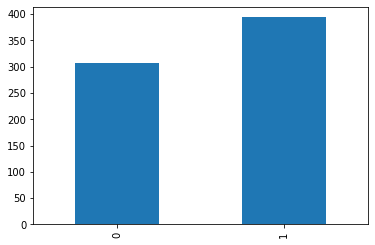

In [281]:
# Check for class imbalance
y.value_counts().sort_values().plot(kind = 'bar');

No class imbalance observed

## Logistic Regression with Lasso Penalty

**GridSearchCV for tuning Parameters**

In [270]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)

param_testing = {'C': [0.01,0.1,1.10]}

gr = GridSearchCV(LogisticRegression(penalty='l1', 
                                     solver='liblinear',  
                                     tol=0.0001, 
                                     max_iter=10000, 
                                     intercept_scaling=1.0, 
                                     multi_class='auto', 
                                     random_state=42),
                  param_testing,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


{'C': 1.1} 0.7519747235387045


LogisticRegression(C=1.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1.0, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Run the Model**

In [274]:
lr = LogisticRegression(C = 1.1,
                          penalty='l1', 
                          solver='liblinear',  
                          tol=0.0001, 
                          max_iter=10000, 
                          intercept_scaling=1.0, 
                          multi_class='auto', 
                          random_state=42)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train,y_train)
    predictions = lr.predict(X_test)
    final_score.append(accuracy_score(y_test, predictions))
    print("Accuracy Score:" ,accuracy_score(y_test, predictions))    
    
logistic_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train,y_train)
    predictions = lr.predict(X_train)
    final_score_train.append(accuracy_score(y_train, predictions))
    print("Accuracy Score:" ,accuracy_score(y_train, predictions))
    
logistic_train = np.mean(final_score_train)

Fold: 1
Accuracy Score: 0.8169014084507042
Fold: 2
Accuracy Score: 0.7887323943661971
Fold: 3
Accuracy Score: 0.7323943661971831
Fold: 4
Accuracy Score: 0.704225352112676
Fold: 5
Accuracy Score: 0.8
Fold: 6
Accuracy Score: 0.6571428571428571
Fold: 7
Accuracy Score: 0.7428571428571429
Fold: 8
Accuracy Score: 0.7857142857142857
Fold: 9
Accuracy Score: 0.8115942028985508
Fold: 10
Accuracy Score: 0.7391304347826086
Fold: 1
Accuracy Score: 0.7559429477020603
Fold: 2
Accuracy Score: 0.7480190174326465
Fold: 3
Accuracy Score: 0.7749603803486529
Fold: 4
Accuracy Score: 0.7638668779714739
Fold: 5
Accuracy Score: 0.7563291139240507
Fold: 6
Accuracy Score: 0.7879746835443038
Fold: 7
Accuracy Score: 0.7642405063291139
Fold: 8
Accuracy Score: 0.7721518987341772
Fold: 9
Accuracy Score: 0.7598736176935229
Fold: 10
Accuracy Score: 0.7693522906793049


**Plot test accuracy vs. train accuracy**

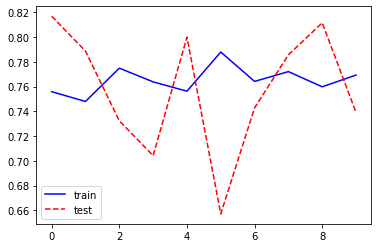

In [275]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Although our mean train and test error rates are pretty close. Test error has high variance. We have only tuned lambda parameter as requested in the question with GridSearchCV and used a c value of 1.1. The high variance could be due to the noise in our training data.Also, it could be due to need of scaling/normalization in our data. We were able to predict %75 of the classes from test data shown by our mean accuracy score. Mean values of train and test scores are almost the same so we can say no overfitting.

# Decision Tree

**GridSearchCV for tuning Parameters**

In [286]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)

# We will try these parameters seperately because when tried together they do not give the best result
param_testing_depth = {'max_depth':np.arange(1,100,1)}  
# {'max_depth': 4} 0.7061611374407583
param_testing_minsamples = {'min_samples_leaf':np.arange(1,100,1)}  ,
# {'min_samples_leaf': 26} 0.7124802527646129

gr = GridSearchCV(DecisionTreeClassifier(random_state=42, max_depth=4,min_samples_leaf = 26),
                  param_testing_minsamples,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 99 candidates, totalling 990 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'min_samples_leaf': 26} 0.7124802527646129


[Parallel(n_jobs=1)]: Done 990 out of 990 | elapsed:   10.5s finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=26, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

**Run the Model**

In [311]:
dt = DecisionTreeClassifier(random_state=42,max_depth=4,min_samples_leaf = 26)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train,y_train)
    predictions = dt.predict(X_test)
    final_score.append(accuracy_score(y_test, predictions))
    print("Accuracy Score:" ,accuracy_score(y_test, predictions))    
    
decision_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train,y_train)
    predictions = dt.predict(X_train)
    final_score_train.append(accuracy_score(y_train, predictions))
    print("Accuracy Score:" ,accuracy_score(y_train, predictions))
    
decision_train = np.mean(final_score_train)

Fold: 1
Accuracy Score: 0.6901408450704225
Fold: 2
Accuracy Score: 0.7887323943661971
Fold: 3
Accuracy Score: 0.676056338028169
Fold: 4
Accuracy Score: 0.7605633802816901
Fold: 5
Accuracy Score: 0.7285714285714285
Fold: 6
Accuracy Score: 0.6428571428571429
Fold: 7
Accuracy Score: 0.6428571428571429
Fold: 8
Accuracy Score: 0.6428571428571429
Fold: 9
Accuracy Score: 0.7971014492753623
Fold: 10
Accuracy Score: 0.7536231884057971
Fold: 1
Accuracy Score: 0.7274167987321711
Fold: 2
Accuracy Score: 0.7432646592709984
Fold: 3
Accuracy Score: 0.7432646592709984
Fold: 4
Accuracy Score: 0.751188589540412
Fold: 5
Accuracy Score: 0.7310126582278481
Fold: 6
Accuracy Score: 0.7420886075949367
Fold: 7
Accuracy Score: 0.75
Fold: 8
Accuracy Score: 0.7420886075949367
Fold: 9
Accuracy Score: 0.7472353870458136
Fold: 10
Accuracy Score: 0.7456556082148499


**Plot test accuracy vs. train accuracy**

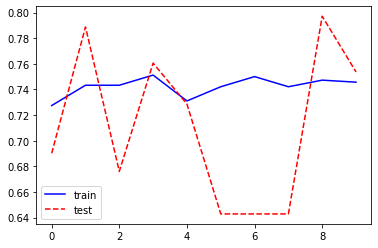

In [313]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our mean train accuracy is 0.75 whereas our mean test accuracy is 0.71. Test error has high variance again. The high variance could be due to the noise in our training data. However, since tree based models are not affected by scaling it is not due to neeed for scaling. We were able to predict %71 of the classes from test data shown by our mean accuracy score. This is comparably less than our LogisticRegression Scores. There is no indication of overfitting or underfitting for test set since the accuracy scores jump up and down. There could be slight over fitting for train data looking at the scores over the 10 folds for test and train data.

# Random Forest

**GridSearchCV for tuning Parameters**

In [307]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)

# only asked to tune number of features to do a split
# Max_features should be between 0,n_features(We have 14 features)
param_testing_m = {'max_features':np.arange(1,14,1)}  
# {'max_features': 3} 0.740916271721959


gr = GridSearchCV(RandomForestClassifier(max_depth=9, 
                                              random_state=0,
                                              min_samples_leaf = 5,
                                              n_estimators = 500)
                  ,param_testing_m,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.2min finished


{'max_features': 3} 0.740916271721959


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

**Run the Model**

In [308]:
rf = RandomForestClassifier(max_depth=9, random_state=0,min_samples_leaf = 5,n_estimators = 500,max_features = 3)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train,y_train)
    predictions = rf.predict(X_test)
    final_score.append(accuracy_score(y_test, predictions))
    print("Accuracy Score:" ,accuracy_score(y_test, predictions))    
    
random_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train,y_train)
    predictions = rf.predict(X_train)
    final_score_train.append(accuracy_score(y_train, predictions))
    print("Accuracy Score:" ,accuracy_score(y_train, predictions))
    
random_train = np.mean(final_score_train)

Fold: 1
Accuracy Score: 0.7464788732394366
Fold: 2
Accuracy Score: 0.8169014084507042
Fold: 3
Accuracy Score: 0.7183098591549296
Fold: 4
Accuracy Score: 0.6901408450704225
Fold: 5
Accuracy Score: 0.8142857142857143
Fold: 6
Accuracy Score: 0.6285714285714286
Fold: 7
Accuracy Score: 0.7
Fold: 8
Accuracy Score: 0.7142857142857143
Fold: 9
Accuracy Score: 0.855072463768116
Fold: 10
Accuracy Score: 0.7536231884057971
Fold: 1
Accuracy Score: 0.8684627575277337
Fold: 2
Accuracy Score: 0.8637083993660856
Fold: 3
Accuracy Score: 0.8684627575277337
Fold: 4
Accuracy Score: 0.8637083993660856
Fold: 5
Accuracy Score: 0.8639240506329114
Fold: 6
Accuracy Score: 0.8670886075949367
Fold: 7
Accuracy Score: 0.870253164556962
Fold: 8
Accuracy Score: 0.870253164556962
Fold: 9
Accuracy Score: 0.8688783570300158
Fold: 10
Accuracy Score: 0.8672985781990521


**Plot test accuracy vs. train accuracy**

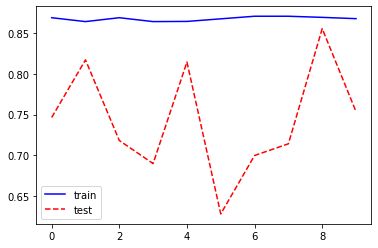

In [310]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our mean train accuracy is 0.86 whereas our mean test accuracy is 0.74. Test error has high variance again. The high variance could be due to the noise in our training data. However, since tree based models are not affected by scaling it is not due to neeed for scaling. For this we can say our model overfitted the train data which can be expected because we have about ~600 lines of data. And overfitting is expected for such small data.

# Stochastic Gradient Boosting (SGB):

**GridSearchCV for tuning Parameters**

In [322]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)



param_testing_depth = {'max_depth':np.arange(1,14,1)}  
# {'max_depth': 2} 0.7282780410742496
param_testing_trees = {'n_estimators':np.arange(300,500,50)}
# {'n_estimators': 350} 0.7456556082148499
param_testing_learning = {'learning_rate':np.arange(0.01,0.1,0.05)} 
# {'learning_rate': 0.01} 0.7456556082148499



gr = GridSearchCV(GradientBoostingClassifier(random_state=42,max_depth = 2,n_estimators = 350)
                  ,param_testing_learning,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.5s finished


{'learning_rate': 0.01} 0.7456556082148499


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=350,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

**Run the Model**

In [325]:
gb = GradientBoostingClassifier(random_state=42,max_depth = 2,n_estimators = 350, learning_rate = 0.01)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gb.fit(X_train,y_train)
    predictions = gb.predict(X_test)
    final_score.append(accuracy_score(y_test, predictions))
    print("Accuracy Score:" ,accuracy_score(y_test, predictions))    
    
gradient_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gb.fit(X_train,y_train)
    predictions = gb.predict(X_train)
    final_score_train.append(accuracy_score(y_train, predictions))
    print("Accuracy Score:" ,accuracy_score(y_train, predictions))
    
gradient_train = np.mean(final_score_train)

Fold: 1
Accuracy Score: 0.8028169014084507
Fold: 2
Accuracy Score: 0.8028169014084507
Fold: 3
Accuracy Score: 0.676056338028169
Fold: 4
Accuracy Score: 0.7183098591549296
Fold: 5
Accuracy Score: 0.8428571428571429
Fold: 6
Accuracy Score: 0.6142857142857143
Fold: 7
Accuracy Score: 0.7142857142857143
Fold: 8
Accuracy Score: 0.6714285714285714
Fold: 9
Accuracy Score: 0.8115942028985508
Fold: 10
Accuracy Score: 0.7391304347826086
Fold: 1
Accuracy Score: 0.7797147385103012
Fold: 2
Accuracy Score: 0.7781299524564184
Fold: 3
Accuracy Score: 0.7892234548335975
Fold: 4
Accuracy Score: 0.7765451664025357
Fold: 5
Accuracy Score: 0.7800632911392406
Fold: 6
Accuracy Score: 0.7927215189873418
Fold: 7
Accuracy Score: 0.7863924050632911
Fold: 8
Accuracy Score: 0.7800632911392406
Fold: 9
Accuracy Score: 0.7788309636650869
Fold: 10
Accuracy Score: 0.7819905213270142


In [327]:
gradient_train

0.7823675303524067

In [328]:
gradient_test

0.7393581780538303

**Plot test accuracy vs. train accuracy**

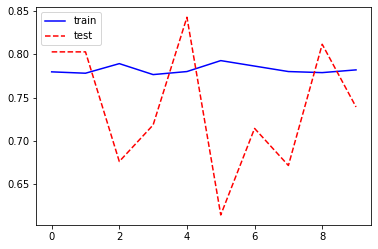

In [326]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our mean train accuracy is 0.78 whereas our mean test accuracy is 0.73. Test error has high variance as usual. The high variance could be due to the noise in our training data. For this we can say our model overfitted the train data which can be expected because we have about ~600 lines of data. And overfitting is expected for such small data for complex models

**Let's compare the results from all algorithms**

In [331]:
# Add train and test scores for all Algorithms
classification_algorithm_df = pd.DataFrame(data = {"train":[logistic_train,decision_train,random_train,gradient_train],
                                                   "test":[logistic_test,decision_test,random_test,gradient_test]})
classification_algorithm_df.index = ["LogisticRegression","DecisionTree","RandomForest","GradientBoosting"]
classification_algorithm_df

,train,test
LogisticRegression,0.765271,0.757869
DecisionTree,0.742322,0.712336
RandomForest,0.782368,0.739358
GradientBoosting,0.782368,0.739358


We see that Logistic Regression with Lasso penalty has the highest test accuracy which is expected because our data size is very small about 600 rows that is why the complex models are expected to overfit and produce lower accuracy on test data.

## 1.Regression - <span style="color:gray"> Predict the total number of goals</span>

**Import Packages**

In [454]:
# Import some additional packages
from sklearn.metrics import mean_squared_error
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from yellowbrick.regressor import ManualAlphaSelection

**Create column total number of goals**

In [455]:
matches["total"] = matches["home_score"] + matches["away_score"]

**Set X(features) and y(target) variables**

In [456]:
X = matches.drop(['match_id','match_status',
       'match_live', 'match_hometeam_name', 'match_awayteam_name',
       'home_score', 'away_score', 'match_hometeam_halftime_score',
       'match_awayteam_halftime_score', 'match_hometeam_extra_score',
       'match_awayteam_extra_score', 'match_hometeam_penalty_score',
       'match_awayteam_penalty_score', 'league_id', 'datetime', 'Date', 'Time',
       'match_result',"home_points","away_points","total"], axis = 1)

y = matches["total"]

# Algorithms

# LassoCV

**GridSearchCV for tuning Parameters**

In [361]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)



param_testing = {'alpha': [0.01,0.1,1.10]}
# {'alpha': 0.01} -0.38093438179085426

gr = GridSearchCV(Lasso( random_state=42),
                  param_testing,
                  verbose = 1,
                  scoring='neg_mean_absolute_error',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 0.01} -0.38093438179085426


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

**Run the Model**

In [457]:
lr = Lasso(alpha=0.01, random_state=42)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train,y_train)
    predictions = lr.predict(X_test)
    final_score.append(mean_absolute_error(y_test, predictions))
    print("MAE Score:" ,mean_absolute_error(y_test, predictions))    
    
lasso_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train,y_train)
    predictions = lr.predict(X_train)
    final_score_train.append(mean_absolute_error(y_train, predictions))
    print("MAE Score:" ,mean_absolute_error(y_train, predictions))
    
lasso_train = np.mean(final_score_train)

Fold: 1
MAE Score: 0.913230702869423
Fold: 2
MAE Score: 1.0872041555830227
Fold: 3
MAE Score: 1.0847688460515887
Fold: 4
MAE Score: 1.0435433247075925
Fold: 5
MAE Score: 1.0173723797776024
Fold: 6
MAE Score: 1.0589484994175786
Fold: 7
MAE Score: 1.0334558225410022
Fold: 8
MAE Score: 0.9098127227860934
Fold: 9
MAE Score: 1.0179822156708123
Fold: 10
MAE Score: 0.9968343934975068
Fold: 1
MAE Score: 1.0104729474415597
Fold: 2
MAE Score: 0.9956585041595947
Fold: 3
MAE Score: 0.9924375470117368
Fold: 4
MAE Score: 0.9963389270415798
Fold: 5
MAE Score: 0.9965205008489125
Fold: 6
MAE Score: 0.9971545457829148
Fold: 7
MAE Score: 0.9983156264605353
Fold: 8
MAE Score: 1.0080952695844412
Fold: 9
MAE Score: 1.0021340401416146
Fold: 10
MAE Score: 1.0015616933084397


In [459]:
lasso_train

0.999868960178133

In [460]:
lasso_test

1.0163153062902224

**Plot test accuracy vs. train accuracy**

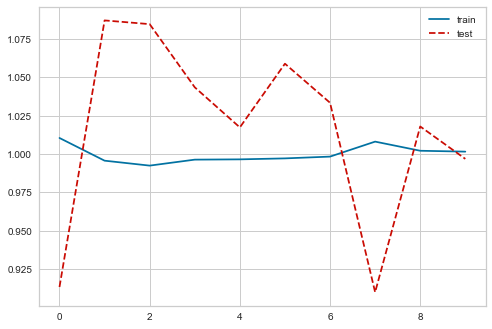

In [458]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our average train score is 0.99 and test score is 1.01. They are very close however test scores have high variance. And overfitting/underfitting situation changes from fold to fold. For example for fold 1 train data is underfitted but for fold 
7 train data is overfitted.

# Decision Tree

**GridSearchCV for tuning Parameters**

In [369]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)

# We will try these parameters seperately because when tried together they do not give the best result
param_testing_depth = {'max_depth':np.arange(1,100,1)}  
# {'max_depth': 4} -0.0330188679245283
param_testing_minsamples = {'min_samples_leaf':np.arange(1,100,1)}  ,
# {'min_samples_leaf': 1} -0.0330188679245283

gr = GridSearchCV(DecisionTreeClassifier(random_state=42,max_depth = 4),
                  param_testing_minsamples,
                  verbose = 1,
                  scoring='neg_mean_absolute_error',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 99 candidates, totalling 990 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'min_samples_leaf': 1} -0.0330188679245283


[Parallel(n_jobs=1)]: Done 990 out of 990 | elapsed:    7.9s finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

**Run the Model**

In [461]:
dt = DecisionTreeClassifier(random_state=42,max_depth=4,min_samples_leaf = 1)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train,y_train)
    predictions = dt.predict_proba(X_test)[:,1]
    final_score.append(mean_absolute_error(y_test, predictions))
    print("MAE Score:" ,mean_absolute_error(y_test, predictions))    
    
decision_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt.fit(X_train,y_train)
    predictions = dt.predict_proba(X_train)[:,1]
    final_score_train.append(mean_absolute_error(y_train, predictions))
    print("MAE Score:" ,mean_absolute_error(y_train, predictions))
    
decision_train = np.mean(final_score_train)

Fold: 1
MAE Score: 2.8153393184827293
Fold: 2
MAE Score: 2.844984531986539
Fold: 3
MAE Score: 2.7811395884524313
Fold: 4
MAE Score: 2.731600184591599
Fold: 5
MAE Score: 2.726149271182712
Fold: 6
MAE Score: 2.714791774149825
Fold: 7
MAE Score: 2.6853142948631703
Fold: 8
MAE Score: 2.681292262785016
Fold: 9
MAE Score: 2.676494781189647
Fold: 10
MAE Score: 2.617652751604087
Fold: 1
MAE Score: 2.7111584886311384
Fold: 2
MAE Score: 2.7062647034304033
Fold: 3
MAE Score: 2.7275418835534
Fold: 4
MAE Score: 2.722107985228149
Fold: 5
MAE Score: 2.731298523071531
Fold: 6
MAE Score: 2.724532148386809
Fold: 7
MAE Score: 2.7329567903799417
Fold: 8
MAE Score: 2.727138301363371
Fold: 9
MAE Score: 2.738622916037635
Fold: 10
MAE Score: 2.7423315371592354


**Plot test accuracy vs. train accuracy**

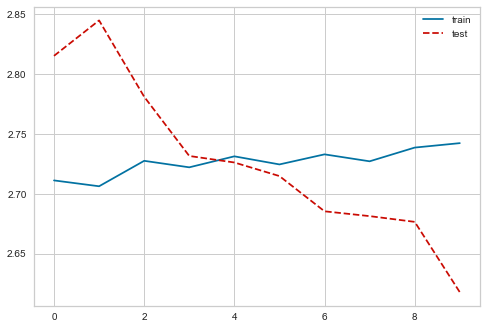

In [462]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our mean train and test error rates are very close. Test error has high variance. We have only tuned max_depth and minimum samples in a leaf parameters  as requested in the question with GridSearchCV.The high variance could be due to the noise in our training data. Since most of the test scores are below out of 10 folds there is an inclination to overfitting for train data from fold 4-10.

# Random Forest

**GridSearchCV for tuning Parameters**

In [374]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)

# only asked to tune number of features to do a split
# Max_features should be between 0,n_features(We have 14 features)
param_testing_m = {'max_features':np.arange(1,14,1)}  
# {'max_features': 11} 0.9921383647798742


gr = GridSearchCV(RandomForestClassifier(max_depth=9, 
                                              random_state=0,
                                              min_samples_leaf = 5,
                                              n_estimators = 500)
                  ,param_testing_m,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:  3.0min finished


{'max_features': 11} 0.9921383647798742


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=11, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

**Run the Model**

In [464]:
rf = RandomForestClassifier(max_depth=9, random_state=0,min_samples_leaf = 5,n_estimators = 500,max_features = 11)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train,y_train)
    predictions = rf.predict_proba(X_test)[:,1]
    final_score.append(mean_absolute_error(y_test, predictions))
    print("MAE Score:" ,mean_absolute_error(y_test, predictions))    
    
random_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train,y_train)
    predictions = rf.predict_proba(X_train)[:,1]
    final_score_train.append(mean_absolute_error(y_train, predictions))
    print("MAE Score:" ,mean_absolute_error(y_train, predictions))
    
random_train = np.mean(final_score_train)

Fold: 1
MAE Score: 2.8119500072434174
Fold: 2
MAE Score: 2.847511221012299
Fold: 3
MAE Score: 2.773123635838805
Fold: 4
MAE Score: 2.724976122440725
Fold: 5
MAE Score: 2.716818469540792
Fold: 6
MAE Score: 2.724526680023764
Fold: 7
MAE Score: 2.6884972148967927
Fold: 8
MAE Score: 2.682439872431628
Fold: 9
MAE Score: 2.6916577477434314
Fold: 10
MAE Score: 2.609281823215753
Fold: 1
MAE Score: 2.7118661927768337
Fold: 2
MAE Score: 2.7099155948889853
Fold: 3
MAE Score: 2.7195210545960715
Fold: 4
MAE Score: 2.7256618544657956
Fold: 5
MAE Score: 2.7253312837255366
Fold: 6
MAE Score: 2.7248827531742714
Fold: 7
MAE Score: 2.7286727783312155
Fold: 8
MAE Score: 2.7307461774767767
Fold: 9
MAE Score: 2.732022571874855
Fold: 10
MAE Score: 2.7386483661141843


**Plot test accuracy vs. train accuracy**

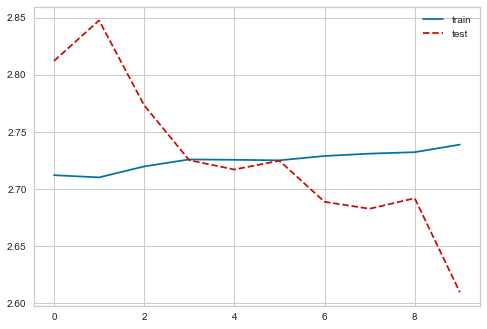

In [465]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Our mean train score is 2.7 and our mean test accuracy is 2.7. Test error has high variance again. The high variance could be due to the noise in our training data. However, since tree based models are not affected by scaling it is not due to neeed for scaling. For this we can say our model overfitted the train data which can be expected because we have about ~600 lines of data. And overfitting is expected for such small data. Again can be seen for most folds model overfitted train data.

# Stochastic Gradient Boosting (SGB):

**GridSearchCV for tuning Parameters**

In [381]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)



param_testing_depth = {'max_depth':np.arange(1,14,1)}  
# {'max_depth': 1} 1.0
param_testing_trees = {'n_estimators':np.arange(300,500,50)}
# {'n_estimators': 300} 1.0
param_testing_learning = {'learning_rate':np.arange(0.01,0.1,0.05)} 
# {'learning_rate': 0.01} 1.0



gr = GridSearchCV(GradientBoostingClassifier(random_state=42, max_depth = 1, n_estimators = 300)
                  ,param_testing_learning,
                  verbose = 1,
                  scoring='accuracy',
                  cv = skf)

    
gr.fit(X_train,y_train)
print(gr.best_params_, gr.best_score_)
best_estimator = gr.best_estimator_
best_estimator

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.1min finished


{'learning_rate': 0.01} 1.0


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

**Run the Model**

In [467]:
gb = GradientBoostingClassifier(random_state=42,max_depth = 1,n_estimators = 350, learning_rate = 0.01)


# Test Score
final_score = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gb.fit(X_train,y_train)
    predictions = gb.predict_proba(X_test)[:,1]
    final_score.append(mean_absolute_error(y_test, predictions))
    print("MAE Score:" ,mean_absolute_error(y_test, predictions))    
    
gradient_test = np.mean(final_score)

# Train Score
final_score_train = []
# Stratified KFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=False)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold:" , fold +1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gb.fit(X_train,y_train)
    predictions = gb.predict_proba(X_train)[:,1]
    final_score_train.append(mean_absolute_error(y_train, predictions))
    print("MAE Score:" ,mean_absolute_error(y_train, predictions))
    
gradient_train = np.mean(final_score_train)

Fold: 1
MAE Score: 2.8313718569558803
Fold: 2
MAE Score: 2.842874414740875
Fold: 3
MAE Score: 2.7743032901915186
Fold: 4
MAE Score: 2.7288351608144166
Fold: 5
MAE Score: 2.7199076584995856
Fold: 6
MAE Score: 2.7210516113219994
Fold: 7
MAE Score: 2.683792698309483
Fold: 8
MAE Score: 2.6810184212342554
Fold: 9
MAE Score: 2.682679550923021
Fold: 10
MAE Score: 2.612469200717326
Fold: 1
MAE Score: 2.7128662324523325
Fold: 2
MAE Score: 2.7142134022907456
Fold: 3
MAE Score: 2.722580377670923
Fold: 4
MAE Score: 2.728865501987982
Fold: 5
MAE Score: 2.7287404765852603
Fold: 6
MAE Score: 2.7294971513087956
Fold: 7
MAE Score: 2.732713003535615
Fold: 8
MAE Score: 2.7352160280349627
Fold: 9
MAE Score: 2.736877998783582
Fold: 10
MAE Score: 2.7430390399252165


**Plot test accuracy vs. train accuracy**

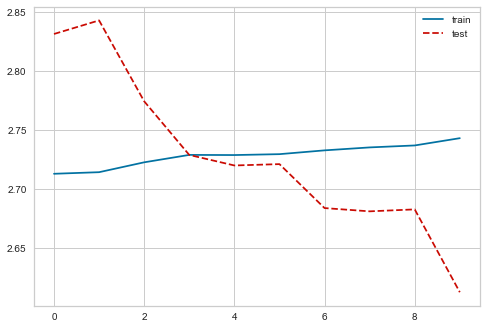

In [470]:
fig, ax = plt.subplots()
ax.plot(final_score_train, '-b', label='train')
ax.plot(final_score, '--r', label='test')
leg = ax.legend();

Train error and test error are the same. Again there is overfitting over some folds of cross validation for example for fold 1 our test set seems to be overfitting but for fold 8 train set is overfitting. Test scores have high variance

**Let's compare the results from all algorithms**

In [472]:
# Add train and test scores for all Algorithms
regression_algorithm_df = pd.DataFrame(data = {"train":[lasso_train,decision_train,random_train,gradient_train],
                                                   "test":[lasso_test,decision_test,random_test,gradient_test]})
regression_algorithm_df.index = ["Lasso","DecisionTree","RandomForest","GradientBoosting"]
regression_algorithm_df

,train,test
Lasso,0.999869,1.016315
DecisionTree,2.726395,2.727476
RandomForest,2.724727,2.727078
GradientBoosting,2.728461,2.727830


We see that Lasso Regression lowest error. Since we have a handful of data complex models werent expected to yield better results and they didn't. For classification and regression problems we have observed that a simple logistic regression model worked best. Models other than Lasso are very close in scores.There is still improvement for models especially with high variances of test sets even though the mean scores of test and train sets are very close. Options are to use a higher regularization, scale/normalize data,use a different metric... We have used accuracy for classification and mean absolute error for regression.Since our target is not imbalanced accuracy will work for us and give the ratio of true predictions to total predictions. We could have used RMSE for regression as a metric but it would not make a difference for our results. Since Lasso is the leading algorithm by far and the other are almost identical.